In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pingouin as pg
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns 
from statannot import add_stat_annotation
import os
import copy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from scipy import stats
from plotly.subplots import make_subplots
from numpy import polyfit, poly1d
from scipy.signal import lfilter, savgol_filter
from sklearn import preprocessing
from scipy.stats import entropy

# %matplotlib inline


C:\A\software\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [27]:
def interpolate_pupil(data, window=90):
    data['LeftPupilD'][data['LeftPupilD']<0] = np.nan
    data['RightPupilD'][data['RightPupilD']<0] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    std_left = np.std(data['LeftPupilD'])
    std_right = np.std(data['RightPupilD'])
    mean_left = np.mean(data['LeftPupilD'])
    mean_right = np.mean(data['RightPupilD'])
    data['LeftPupilD'][np.abs(data['LeftPupilD']-mean_left)>3*std_left] = np.nan
    data['RightPupilD'][np.abs(data['RightPupilD']-mean_right)>3*std_right] = np.nan
    data = data.interpolate(method='linear',axis=0,limit_direction ='both')
    data.dropna(axis=0)
    data_s = SG_fil(data,window+1,2)
    return data_s

def SG_fil(data,window,order=2):
    df = data.copy()
    column_name = df.columns.tolist()
    df_new = pd.DataFrame(columns=column_name)
    for n in column_name:
        df_new[n] = savgol_filter(df.loc[:,n],window,order)
    return df_new  

def left_adjust(coeff_left,x,power):
    if power == 2:
        y = coeff_left[0] * np.power(x,power) + coeff_left[1] * np.power(x,power-1) + coeff_left[2] * np.power(x,power-2)
    if power == 5:
        y = coeff_left[0] * np.power(x,power) + coeff_left[1] * np.power(x,power-1) + coeff_left[2] * np.power(x,power-2) + coeff_left[3] * np.power(x,power-3) + coeff_left[4] * np.power(x,power-4) + coeff_left[5] * np.power(x,power-5)
    return y
def right_adjust(coeff_right,x,power):
    if power == 2:
        y = coeff_right[0] * np.power(x,power) + coeff_right[1] * np.power(x,power-1) + coeff_right[2] * np.power(x,power-2)
    if power == 5:
        y = coeff_right[0] * np.power(x,power) + coeff_right[1] * np.power(x,power-1) + coeff_right[2] * np.power(x,power-2) + coeff_right[3] * np.power(x,power-3) + coeff_right[4] * np.power(x,power-4) + coeff_right[5] * np.power(x,power-5)
    return y

def get_adjust_pupil(lumin, pupil_left, pupil_right, left_average, right_average, power_coeff=2, multi_lumin = 255):
    # coeff_left = [2.52023698e-03, -1.53182328e-01, 4.86556856e+00]
    # coeff_right = [2.50544091e-03, -1.56393294e-01, 5.05585498e+00]
    coeff_left = [2.52023698e-03, -1.53182328e-01, left_average]
    coeff_right = [2.50544091e-03, -1.56393294e-01, right_average]
    lumin_adj = lumin.values.ravel()*multi_lumin
    left_original_pupil = pupil_left.values.ravel()
    right_original_pupil = pupil_right.values.ravel()
    left_adjust_pupil = left_adjust(coeff_left,lumin_adj,power_coeff).ravel()
    right_adjust_pupil = right_adjust(coeff_right,lumin_adj,power_coeff).ravel()
    left_cogload = left_original_pupil - left_adjust_pupil
    right_cogload = right_original_pupil - right_adjust_pupil
    return left_cogload, right_cogload, left_adjust_pupil, right_adjust_pupil


In [32]:
path1 = 'D:/Tianyu/code/python/nist_phase_1/code/Data_NASA/'
path = path1
data_raw=[]
data_collection = ["LeftPupilD","RightPupilD","Lumin","CollisionTargetName","Cube1Name","Cube1X","Cube1Y","Cube1Z",\
            "Cube4Name","Cube4X","Cube4Y","Cube4Z","Cube5Name","Cube5X","Cube5Y","Cube5Z","Cube6Name","Cube6X","Cube6Y",\
                "Cube6Z","HitCube","CollisionTargetDiff","HitCubeDiff","left_adjust_pupil","right_adjust_pupil","left_cogload","right_cogload"]
for home, dirs, files in os.walk(path):
    if not os.path.exists(home + "_cogload/"):
        os.mkdir(home + "_cogload/")
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t = t[200:-1].reset_index()
        t[["LeftPupilD_smooth","RightPupilD_smooth","Lumin_smooth"]] = interpolate_pupil(t[["LeftPupilD","RightPupilD","Lumin"]])
        t[["CollisionTargetName","HitCube"]] = t[["CollisionTargetName","HitCube"]].fillna('')
        t[["CollisionTargetDiff","HitCubeDiff"]] = t[["CollisionTargetName","HitCube"]].ne(t[["CollisionTargetName","HitCube"]].shift().bfill()).astype(int) # faster
        # t[["CollisionTargetDiff","HitCubeDiff"]] = (t[["CollisionTargetName","HitCube"]]!= t[["CollisionTargetName","HitCube"]].shift()).astype(int) # slower
        (left_cogload, right_cogload,left_adjust_pupil, right_adjust_pupil) = get_adjust_pupil(t.Lumin_smooth, t.LeftPupilD_smooth, t.RightPupilD_smooth, np.average(t.LeftPupilD),\
             np.average(t.RightPupilD), multi_lumin=25)
        t["left_adjust_pupil"] = left_adjust_pupil
        t["right_adjust_pupil"] = right_adjust_pupil
        t["left_cogload"] = left_cogload
        t["right_cogload"] = right_cogload
        left_cogload_to0 = left_cogload - np.min(left_cogload)
        right_cogload_to0 = right_cogload - np.min(right_cogload)
        t["left_cogload_to0"] = left_cogload_to0
        t["right_cogload_to0"] = right_cogload_to0


        t.index = range(len(t))
        # t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        # data_raw.append(t[data_collection])
        # data_raw.append(t)

        t.to_csv(home + "_cogload/" + filename)

# participant_num = int(len(data_raw)/2)


D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
D:\Tianyu\software\anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

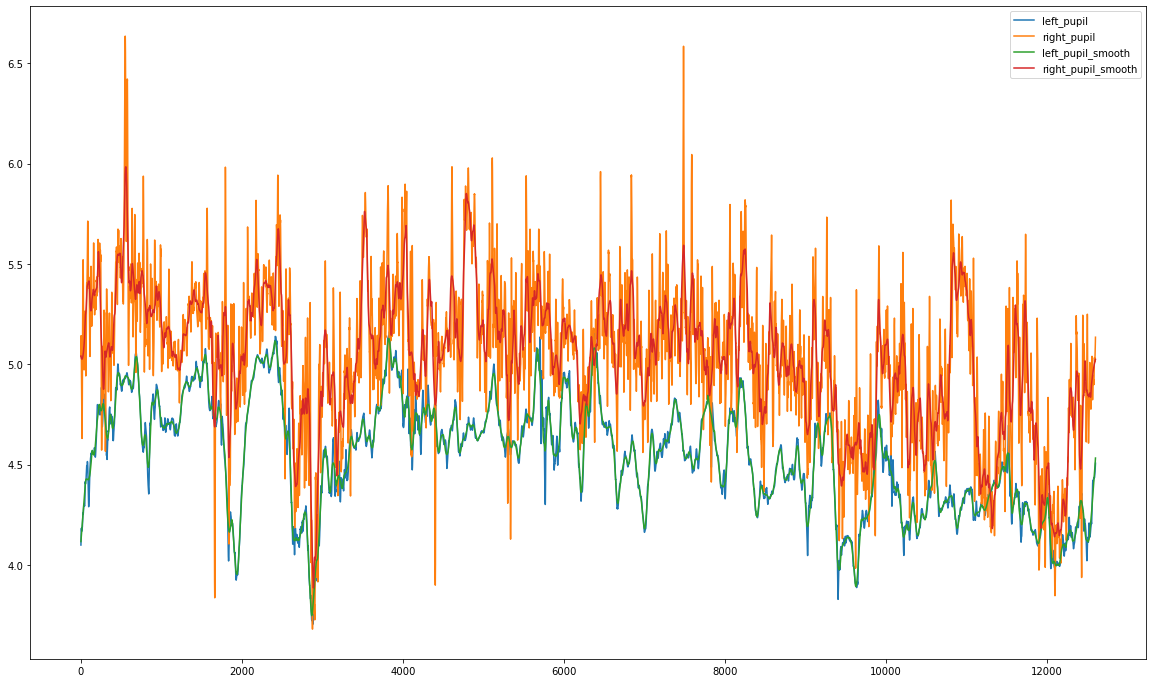

In [30]:
# for test, choose which file
data_index = 1
# start frame
start = 0
# start = 11100
# end frame
end = len(data_raw[data_index][['Lumin']].values)
# end = 11200
# lumin times adjustion
multi_lumin = 1

x_lumin = data_raw[data_index][['Lumin']][start:end].values.ravel()*multi_lumin
left_original_pupil = np.array(data_raw[data_index][['LeftPupilD']][start:end]).ravel()
right_original_pupil = np.array(data_raw[data_index][['RightPupilD']][start:end]).ravel()
right_smooth_pupil = np.array(data_raw[data_index][['RightPupilD_smooth']][start:end]).ravel()
left_smooth_pupil = np.array(data_raw[data_index][['LeftPupilD_smooth']][start:end]).ravel()


left_cogload = np.array(data_raw[data_index][['left_cogload']][start:end]).ravel()
right_cogload = np.array(data_raw[data_index][['right_cogload']][start:end]).ravel()
left_adjust_pupil = np.array(data_raw[data_index][['left_adjust_pupil']][start:end]).ravel()
right_adjust_pupil = np.array(data_raw[data_index][['right_adjust_pupil']][start:end]).ravel()

# rolling_right = np.array(data_raw[data_index][['RightPupilD']][start:end].rolling(10,closed="both").median().fillna(method="bfill").fillna(method="ffill")).ravel()
plt.figure(figsize=(20, 12))
plt.plot(left_original_pupil, label='left_pupil')
plt.plot(right_original_pupil, label='right_pupil')
plt.plot(left_smooth_pupil, label='left_pupil_smooth')
plt.plot(right_smooth_pupil, label='right_pupil_smooth')
# plt.plot(left_adjust_pupil, label='left_lumin_adj')
# plt.plot(right_adjust_pupil, label='right_lumin_adj')
# plt.plot(left_cogload, label='left_cogload')
# plt.plot(right_cogload, label='right_cogload')

# plt.plot(rolling_right, label='rolling_right')
# plt.plot(x_lumin*25, label='lumin')
plt.legend()
plt.show()

In [11]:
data_index = 5
change_list_hit = data_raw[data_index]["HitCubeDiff"][data_raw[data_index]["HitCubeDiff"] == 1]
change_list_cillision = data_raw[data_index]["CollisionTargetDiff"][data_raw[data_index]["CollisionTargetDiff"] == 1]
# data_raw[data_index]["CollisionTargetDiff"][data_raw[data_index]["CollisionTargetDiff"] == 1]

In [30]:
data_raw[data_index][["CollisionTargetName","HitCube"]].iloc[change_list_cillision.index[0]]


CollisionTargetName    Object_Start
HitCube                            
Name: 1674, dtype: object

In [33]:
cube_list = ["Object_White", "Object_Purple", "Object4_Green", "Object4_Blue"]
target_list = ["Object_White_ID1", "Object_Purple_ID2", "Object4_Green_ID3", "Object4_Blue_ID4"]
### sample from raw data 
rate = 1
data_image = copy.deepcopy(data_raw[data_index])
subset = data_image[::rate]

## 3D Stastic ###
df = subset[subset["CollisionTargetName"]=="Object_White"]

fig = px.scatter_3d(df, x='RobotX', y='RobotY', z='RobotZ',
            color='left_cogload',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8,) #symbol='CollisionTargetName',symbol_sequence=["cross","circle"]
fig.update_traces(marker_size = 3)

fig.show()

In [21]:
# dir(px.colors.qualitative)
dir(px.colors.sequential)

['Aggrnyl',
 'Aggrnyl_r',
 'Agsunset',
 'Agsunset_r',
 'Blackbody',
 'Blackbody_r',
 'Bluered',
 'Bluered_r',
 'Blues',
 'Blues_r',
 'Blugrn',
 'Blugrn_r',
 'Bluyl',
 'Bluyl_r',
 'Brwnyl',
 'Brwnyl_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'Burg',
 'Burg_r',
 'Burgyl',
 'Burgyl_r',
 'Cividis',
 'Cividis_r',
 'Darkmint',
 'Darkmint_r',
 'Electric',
 'Electric_r',
 'Emrld',
 'Emrld_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Hot',
 'Hot_r',
 'Inferno',
 'Inferno_r',
 'Jet',
 'Jet_r',
 'Magenta',
 'Magenta_r',
 'Magma',
 'Magma_r',
 'Mint',
 'Mint_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'Oryel',
 'Oryel_r',
 'Peach',
 'Peach_r',
 'Pinkyl',
 'Pinkyl_r',
 'Plasma',
 'Plasma_r',
 'Plotly3',
 'Plotly3_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuRd',
 'PuRd_r',
 'Purp',
 'Purp_r',
 'Purples',
 'Purples_r',
 'Purpor',
 'Purpor_r',
 'Rainbow',
 'Rainbow_r',
 'RdBu',
 'RdBu_r',
 'RdPu',
 'RdPu_r',
 'Redor',
 'Redor_r',
 'Reds',
 'Reds_r',
 'Sunset

In [ ]:
path1 = 'D:/Tianyu/code/python/nasa/nasa_data/v_2/'
path = path1
data_raw=[]
data_collection = ["LeftPupilD","RightPupilD","Lumin","CollisionTargetName","Cube1Name","Cube1X","Cube1Y","Cube1Z",\
            "Cube4Name","Cube4X","Cube4Y","Cube4Z","Cube5Name","Cube5X","Cube5Y","Cube5Z","Cube6Name","Cube6X","Cube6Y",\
                "Cube6Z","HitCube","CollisionTargetDiff","HitCubeDiff","left_adjust_pupil","right_adjust_pupil","left_cogload","right_cogload"]
for home, dirs, files in os.walk(path):
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t[["LeftPupilD_smooth","RightPupilD_smooth","Lumin_smooth"]] = interpolate_pupil(t[["LeftPupilD","RightPupilD","Lumin"]])
        t[["CollisionTargetName","HitCube"]] = t[["CollisionTargetName","HitCube"]].fillna('')
        t[["CollisionTargetDiff","HitCubeDiff"]] = t[["CollisionTargetName","HitCube"]].ne(t[["CollisionTargetName","HitCube"]].shift().bfill()).astype(int) # faster
        # t[["CollisionTargetDiff","HitCubeDiff"]] = (t[["CollisionTargetName","HitCube"]]!= t[["CollisionTargetName","HitCube"]].shift()).astype(int) # slower
        (left_cogload, right_cogload,left_adjust_pupil, right_adjust_pupil) = get_adjust_pupil(t.Lumin_smooth, t.LeftPupilD_smooth, t.RightPupilD_smooth, np.average(t.LeftPupilD),\
             np.average(t.RightPupilD), multi_lumin=25)
        t["left_adjust_pupil"] = left_adjust_pupil
        t["right_adjust_pupil"] = right_adjust_pupil
        t["left_cogload"] = left_cogload
        t["right_cogload"] = right_cogload
        left_cogload_to0 = left_cogload - np.min(left_cogload)
        right_cogload_to0 = right_cogload - np.min(right_cogload)
        t["left_cogload_to0"] = left_cogload_to0
        t["right_cogload_to0"] = right_cogload_to0


        t.index = range(len(t))
        # t.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        # data_raw.append(t[data_collection])
        # data_raw.append(t)

        t.to_csv(home + "_cogload/" + filename)

# participant_num = int(len(data_raw)/2)

In [20]:
path = 'D:/Tianyu/code/python/nasa/nasa_data/v_2/'
data_raw=[]
for home, dirs, files in os.walk(path):
    for filename in files:
        t=pd.read_csv(home+"/"+filename,index_col=0)


In [ ]:
vel_cube1_x = []
v_previous = 0
name = 'Cube1X'
for i,v in t[name].iteritems():
    if abs(v-v_previous)>0.5:
        vel_cube1_x.append(0)
    # elif abs(v-v_previous)>0:
    else:
        vel_cube1_x.append(v-v_previous)
    v_previous = v
vel_df = pd.DataFrame({"vel_x":vel_cube1_x[14500:20000]})

In [36]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))
    
m = 2

In [12]:
def get_entropy(t,name,column_name):
    vel_x = []
    vel_y = []
    vel_z = []
    p_x_previous = 0
    p_y_previous = 0
    p_z_previous = 0

    for i,p_x in t[column_name + 'X'].iteritems():
        delta_p_x = p_x-p_x_previous
        if abs(delta_p_x)>0.5:
            vel_x.append(0)
        # elif abs(delta_v_x)>0:
        else:
            vel_x.append(delta_p_x)
        p_x_previous = p_x
    t["vel_x"] = vel_x
    for i,p_y in t[column_name + 'Y'].iteritems():
        delta_p_y = p_y-p_y_previous
        if abs(delta_p_y)>0.5:
            vel_y.append(0)
        # elif abs(delta_v_y)>0:
        else:
            vel_y.append(delta_p_y)
        p_y_previous = p_y
    t["vel_y"] = vel_y
    for i,p_z in t[column_name + 'Z'].iteritems():
        delta_p_z = p_z-p_z_previous
        if abs(delta_p_z)>0.5:
            vel_z.append(0)
        # elif abs(delta_v_z)>0:
        else:
            vel_z.append(delta_p_z)
        p_z_previous = p_z
    t["vel_z"] = vel_z
    
    
    control_group = t.dropna(axis=1)
    control_group['Conditions'][control_group['Conditions'] != "control"] = np.nan
    control_group = control_group.dropna(axis=0)
    control_group.index = range(len(control_group))
    control_pd_groupby = control_group.groupby(['ID'])

    Anchoring_group = t.dropna(axis=1)
    Anchoring_group['Conditions'][Anchoring_group['Conditions'] != "Anchoring"] = np.nan
    Anchoring_group = Anchoring_group.dropna(axis=0)
    Anchoring_group.index = range(len(Anchoring_group))
    Anchoring_pd_groupby = Anchoring_group.groupby(['ID'])

    Asynchronized_group = t.dropna(axis=1)
    Asynchronized_group['Conditions'][Asynchronized_group['Conditions'] != "Asynchronized"] = np.nan
    Asynchronized_group = Asynchronized_group.dropna(axis=0)
    Asynchronized_group.index = range(len(Asynchronized_group))
    Asynchronized_pd_groupby = Asynchronized_group.groupby(['ID'])

    Synchronized_group = t.dropna(axis=1)
    Synchronized_group['Conditions'][Synchronized_group['Conditions'] != "Synchronized"] = np.nan
    Synchronized_group = Synchronized_group.dropna(axis=0)
    Synchronized_group.index = range(len(Synchronized_group))
    Synchronized_pd_groupby = Synchronized_group.groupby(['ID'])
    
    
    control_pos_x_entropy = []
    control_pos_y_entropy = []
    control_pos_z_entropy = []
    control_vel_x_entropy = []
    control_vel_y_entropy = []
    control_vel_z_entropy = []
    control_vel_x_mean = []
    control_vel_y_mean = []
    control_vel_z_mean = []
    for h,d in control_pd_groupby:
        control_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        control_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        control_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        control_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        control_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        control_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        control_vel_x_mean.append(d['vel_x'].values.mean())
        control_vel_y_mean.append(d['vel_y'].values.mean())
        control_vel_z_mean.append(d['vel_z'].values.mean())

    Anchoring_pos_x_entropy = []
    Anchoring_pos_y_entropy = []
    Anchoring_pos_z_entropy = []
    Anchoring_vel_x_entropy = []
    Anchoring_vel_y_entropy = []
    Anchoring_vel_z_entropy = []
    Anchoring_vel_x_mean = []
    Anchoring_vel_y_mean = []
    Anchoring_vel_z_mean = []
    for h,d in Anchoring_pd_groupby:
        Anchoring_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Anchoring_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Anchoring_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Anchoring_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Anchoring_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Anchoring_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Anchoring_vel_x_mean.append(d['vel_x'].values.mean())
        Anchoring_vel_y_mean.append(d['vel_y'].values.mean())
        Anchoring_vel_z_mean.append(d['vel_z'].values.mean())


    Asynchronized_pos_x_entropy = []
    Asynchronized_pos_y_entropy = []
    Asynchronized_pos_z_entropy = []
    Asynchronized_vel_x_entropy = []
    Asynchronized_vel_y_entropy = []
    Asynchronized_vel_z_entropy = []
    Asynchronized_vel_x_mean = []
    Asynchronized_vel_y_mean = []
    Asynchronized_vel_z_mean = []
    for h,d in Asynchronized_pd_groupby:
        Asynchronized_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Asynchronized_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Asynchronized_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Asynchronized_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Asynchronized_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Asynchronized_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Asynchronized_vel_x_mean.append(d['vel_x'].values.mean())
        Asynchronized_vel_y_mean.append(d['vel_y'].values.mean())
        Asynchronized_vel_z_mean.append(d['vel_z'].values.mean())


    Synchronized_pos_x_entropy = []
    Synchronized_pos_y_entropy = []
    Synchronized_pos_z_entropy = []
    Synchronized_vel_x_entropy = []
    Synchronized_vel_y_entropy = []
    Synchronized_vel_z_entropy = []
    Synchronized_vel_x_mean = []
    Synchronized_vel_y_mean = []
    Synchronized_vel_z_mean = []
    for h,d in Synchronized_pd_groupby:
        Synchronized_pos_x_entropy.append(SampEn(d[column_name + 'X'].values, m, r=0.2 * np.std(d[column_name + 'X'].values)))
        Synchronized_pos_y_entropy.append(SampEn(d[column_name + 'Y'].values, m, r=0.2 * np.std(d[column_name + 'Y'].values)))
        Synchronized_pos_z_entropy.append(SampEn(d[column_name + 'Z'].values, m, r=0.2 * np.std(d[column_name + 'Z'].values)))
        Synchronized_vel_x_entropy.append(SampEn(d['vel_x'].values, m, r=0.2 * np.std(d['vel_x'].values)))
        Synchronized_vel_y_entropy.append(SampEn(d['vel_y'].values, m, r=0.2 * np.std(d['vel_y'].values)))
        Synchronized_vel_z_entropy.append(SampEn(d['vel_z'].values, m, r=0.2 * np.std(d['vel_z'].values)))
        Synchronized_vel_x_mean.append(d['vel_x'].values.mean())
        Synchronized_vel_y_mean.append(d['vel_y'].values.mean())
        Synchronized_vel_z_mean.append(d['vel_z'].values.mean())

    a = {
    'control_pos_x_entropy':control_pos_x_entropy,'control_pos_y_entropy':control_pos_y_entropy,'control_pos_z_entropy':control_pos_z_entropy,
    'control_vel_x_entropy':control_vel_x_entropy,'control_vel_y_entropy':control_vel_y_entropy,'control_vel_z_entropy':control_vel_z_entropy,
    'control_vel_x_mean':control_vel_x_mean,'control_vel_y_mean':control_vel_y_mean,'control_vel_z_mean':control_vel_z_mean,

    'Anchoring_pos_x_entropy':Anchoring_pos_x_entropy,'Anchoring_pos_y_entropy':Anchoring_pos_y_entropy,'Anchoring_pos_z_entropy':Anchoring_pos_z_entropy,
    'Anchoring_vel_x_entropy':Anchoring_vel_x_entropy,'Anchoring_vel_y_entropy':Anchoring_vel_y_entropy,'Anchoring_vel_z_entropy':Anchoring_vel_z_entropy,
    'Anchoring_vel_x_mean':Anchoring_vel_x_mean,'Anchoring_vel_y_mean':Anchoring_vel_y_mean,'Anchoring_vel_z_mean':Anchoring_vel_z_mean,

    'Asynchronized_pos_x_entropy':Asynchronized_pos_x_entropy,'Asynchronized_pos_y_entropy':Asynchronized_pos_y_entropy,'Asynchronized_pos_z_entropy':Asynchronized_pos_z_entropy,
    'Asynchronized_vel_x_entropy':Asynchronized_vel_x_entropy,'Asynchronized_vel_y_entropy':Asynchronized_vel_y_entropy,'Asynchronized_vel_z_entropy':Asynchronized_vel_z_entropy,
    'Asynchronized_vel_x_mean':Asynchronized_vel_x_mean,'Asynchronized_vel_y_mean':Asynchronized_vel_y_mean,'Asynchronized_vel_z_mean':Asynchronized_vel_z_mean,

    'Synchronized_pos_x_entropy':Synchronized_pos_x_entropy,'Synchronized_pos_y_entropy':Synchronized_pos_y_entropy,'Synchronized_pos_z_entropy':Synchronized_pos_z_entropy,
    'Synchronized_vel_x_entropy':Synchronized_vel_x_entropy,'Synchronized_vel_y_entropy':Synchronized_vel_y_entropy,'Synchronized_vel_z_entropy':Synchronized_vel_z_entropy,
    'Synchronized_vel_x_mean':Synchronized_vel_x_mean,'Synchronized_vel_y_mean':Synchronized_vel_y_mean,'Synchronized_vel_z_mean':Synchronized_vel_z_mean,
    }
    entropy_df = pd.DataFrame.from_dict(a,orient='index')
    entropy_df = entropy_df.transpose()
    entropy_df.to_csv(home+"/"+ name + "_entropy.csv")

    control_df = pd.DataFrame([
        control_pos_x_entropy,control_pos_y_entropy,control_pos_z_entropy,
        control_vel_x_entropy,control_vel_y_entropy,control_vel_z_entropy,
        control_vel_x_mean,control_vel_y_mean,control_vel_z_mean
        ]).transpose()
    control_df["Groups"] = "Control"

    Anchoring_df = pd.DataFrame([
        Anchoring_pos_x_entropy,Anchoring_pos_y_entropy,Anchoring_pos_z_entropy,
        Anchoring_vel_x_entropy,Anchoring_vel_y_entropy,Anchoring_vel_z_entropy,
        Anchoring_vel_x_mean,Anchoring_vel_y_mean,Anchoring_vel_z_mean
        ]).transpose()
    Anchoring_df["Groups"] = "Anchoring"

    Asynchronized_df = pd.DataFrame([
        Asynchronized_pos_x_entropy,Asynchronized_pos_y_entropy,Asynchronized_pos_z_entropy,
        Asynchronized_vel_x_entropy,Asynchronized_vel_y_entropy,Asynchronized_vel_z_entropy,
        Asynchronized_vel_x_mean,Asynchronized_vel_y_mean,Asynchronized_vel_z_mean
        ]).transpose()
    Asynchronized_df["Groups"] = "Asynchronized"

    Synchronized_df = pd.DataFrame([
        Synchronized_pos_x_entropy,Synchronized_pos_y_entropy,Synchronized_pos_z_entropy,
        Synchronized_vel_x_entropy,Synchronized_vel_y_entropy,Synchronized_vel_z_entropy,
        Synchronized_vel_x_mean,Synchronized_vel_y_mean,Synchronized_vel_z_mean
        ]).transpose()
    Synchronized_df["Groups"] = "Synchronized"

    total_df = pd.concat([control_df,Anchoring_df,Asynchronized_df,Synchronized_df])
    total_df.columns = ["entropy_pos_x","entropy_pos_y","entropy_pos_z","entropy_vel_x","entropy_vel_y","entropy_vel_z","mean_vel_x","mean_vel_y","mean_vel_z","Groups"]
    total_df.to_csv((home+"/"+ name + "_combine.csv"))


In [74]:
path = 'D:/code/python/nasa/data/Trajectory/test/'

locals_name = locals()
column_W = 'Cube6'
column_B = 'Cube5'
column_G = 'Cube4'
column_P = 'Cube1'

for home, dirs, files in os.walk(path):
    for filename in files:
        name = filename[0]
        t=pd.read_csv(home+"/"+filename,index_col=0)
        t['Conditions'] = t['Conditions'].str.strip()
        t['ID'] = t['ID'].str.strip()

        column_name = locals_name['column_' + name]
        print(name)
        # get_entropy(t,name,column_name)
        


P


In [75]:
vel_x = []
vel_y = []
vel_z = []
p_x_previous = 0
p_y_previous = 0
p_z_previous = 0

for i,p_x in t[column_name + 'X'].iteritems():
    delta_p_x = p_x-p_x_previous
    if abs(delta_p_x)>0.5:
        vel_x.append(0)
    # elif abs(delta_v_x)>0:
    else:
        vel_x.append(delta_p_x)
    p_x_previous = p_x
t["vel_x"] = vel_x
for i,p_y in t[column_name + 'Y'].iteritems():
    delta_p_y = p_y-p_y_previous
    if abs(delta_p_y)>0.5:
        vel_y.append(0)
    # elif abs(delta_v_y)>0:
    else:
        vel_y.append(delta_p_y)
    p_y_previous = p_y
t["vel_y"] = vel_y
for i,p_z in t[column_name + 'Z'].iteritems():
    delta_p_z = p_z-p_z_previous
    if abs(delta_p_z)>0.5:
        vel_z.append(0)
    # elif abs(delta_v_z)>0:
    else:
        vel_z.append(delta_p_z)
    p_z_previous = p_z
t["vel_z"] = vel_z


control_group = t.dropna(axis=1)
control_group['Conditions'][control_group['Conditions'] != "control"] = np.nan
control_group = control_group.dropna(axis=0)
control_group.index = range(len(control_group))
control_pd_groupby = control_group.groupby(['ID'])

Anchoring_group = t.dropna(axis=1)
Anchoring_group['Conditions'][Anchoring_group['Conditions'] != "Anchoring"] = np.nan
Anchoring_group = Anchoring_group.dropna(axis=0)
Anchoring_group.index = range(len(Anchoring_group))
Anchoring_pd_groupby = Anchoring_group.groupby(['ID'])

Asynchronized_group = t.dropna(axis=1)
Asynchronized_group['Conditions'][Asynchronized_group['Conditions'] != "Asynchronized"] = np.nan
Asynchronized_group = Asynchronized_group.dropna(axis=0)
Asynchronized_group.index = range(len(Asynchronized_group))
Asynchronized_pd_groupby = Asynchronized_group.groupby(['ID'])

Synchronized_group = t.dropna(axis=1)
Synchronized_group['Conditions'][Synchronized_group['Conditions'] != "Synchronized"] = np.nan
Synchronized_group = Synchronized_group.dropna(axis=0)
Synchronized_group.index = range(len(Synchronized_group))
Synchronized_pd_groupby = Synchronized_group.groupby(['ID'])

<ipython-input-75-81944d517159>:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-75-81944d517159>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\A\software\Anaconda3\lib\site-packages\pandas\core\series.py:992: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

In [92]:
delta_pos = d[[column_name + 'X',column_name + 'Y',column_name + 'Z']][0:1].values - [98.09391,13.35386,-35.24587]

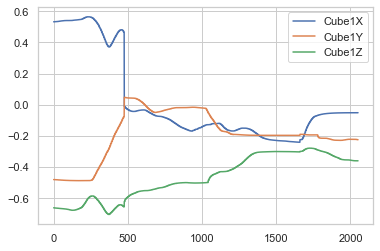

In [108]:
n=0
groups = ['control','Anchoring','Asynchronized','Synchronized']
for h,d in Anchoring_pd_groupby:
    if n == 43:
    # if 1:
        plt.plot(d[column_name + 'X'].values - d[column_name + 'X'].values.mean() - delta_pos.ravel()[0],label=column_name + 'X')
        plt.plot(d[column_name + 'Y'].values - d[column_name + 'Y'].values.mean() - delta_pos.ravel()[1],label=column_name + 'Y')
        plt.plot(d[column_name + 'Z'].values - d[column_name + 'Z'].values.mean() - delta_pos.ravel()[2],label=column_name + 'Z')
        # plt.plot(d['vel_x'].values-0.2,label='vel_x')
        # plt.plot(d['vel_y'].values-0.2,label='vel_y')
        # plt.plot(d['vel_z'].values-0.2,label='vel_z')
        plt.legend()
        plt.show()
        if 1:
            d['group'] = 'process'
            d[column_name + 'X'] = d[column_name + 'X'] - delta_pos.ravel()[0]
            d[column_name + 'Y'] = d[column_name + 'Y'] - delta_pos.ravel()[1]
            d[column_name + 'Z'] = d[column_name + 'Z'] - delta_pos.ravel()[2]
            d = d.append(pd.DataFrame({column_name + 'X':[98.09391],column_name + 'Y':[13.35386],column_name + 'Z':[-35.24587],'group':'start_point'}),ignore_index=True)
            d = d.append(pd.DataFrame({column_name + 'X':[97.27963],column_name + 'Y':[13.61891],column_name + 'Z':[-34.86887],'group':'end_point'}),ignore_index=True)
            fig = px.scatter_3d(d, x=column_name + 'X', y=column_name + 'Y', z=column_name + 'Z',color='group')
                # color='left_cogload',color_continuous_scale=px.colors.sequential.Viridis, opacity=0.8,) #symbol='CollisionTargetName',symbol_sequence=["cross","circle"]
            fig.update_traces(marker_size = 3)
            fig.show()
        break
    n=n+1

In [34]:
name = 'W'
data = pd.read_csv('D:/code/python/nasa/data/Trajectory/result/0402/' + name + '_combine.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
for index,row in data.iteritems():
    if index != 'Groups':
        row[row>0.1] = np.nan

# data_mean = data.mean()
# data_std = data.std()
# for index,row in data.iteritems():
#     if index != 'Groups':
#         row[np.abs(row-data_mean[index])>3*data_std[index]] = np.nan
# data = data.interpolate(method='linear',axis=0,limit_direction ='both')

<ipython-input-34-f28fa8c0c419>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[row>0.1] = np.nan
<ipython-input-34-f28fa8c0c419>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[row>0.1] = np.nan
<ipython-input-34-f28fa8c0c419>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[row>0.1] = np.nan
<ipython-input-34-f28fa8c0c419>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Control v.s. Anchoring: Kruskal-Wallis paired samples, P_val=5.466e-01 stat=3.635e-01
Control v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=1.254e-01 stat=2.348e+00
Control v.s. Synchronized: Kruskal-Wallis paired samples, P_val=4.629e-01 stat=5.388e-01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Anchoring v.s. Asynchronized: Kruskal-Wallis paired samples, P_val=2.163e-01 stat=1.529e+00
Asynchronized v.s. Synchronized: Kruskal-Wallis paired samples, P_val=6.392e-01 stat=2.198e-01
Anchoring v.s. Synchronized: Kruskal-Wallis paired samples, P_val=6.567e-01 stat=1.975e-01


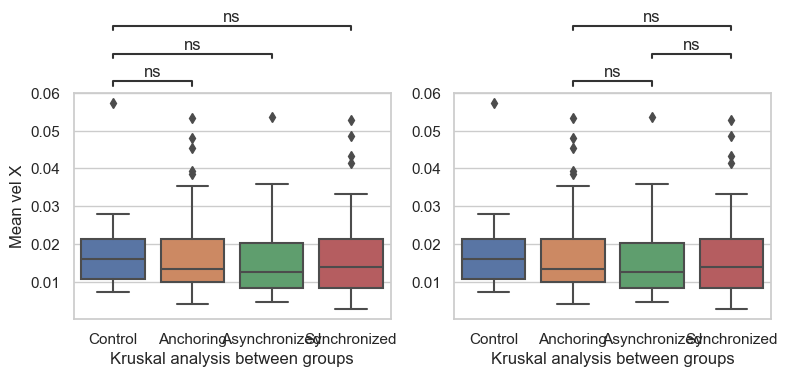

In [35]:
### pair analysis visualization 

sns.set(style = 'whitegrid')
x = 'Groups'
y = 'entropy_pos_x'
hue = 'Groups'
order = ["Control", "Anchoring","Asynchronized","Synchronized"]

fig, axes = plt.subplots(1,2, figsize=(9,3), dpi=100)

if 1:
   axes[0] = sns.boxplot(ax = axes[0], data=data, x=x, y=y, order=order)
   test_results = add_stat_annotation(ax=axes[0], data=data, x=x, y=y, order=order,
                                    box_pairs=[(order[0], order[1]),(order[0], order[2]),(order[0], order[3])],
                                    test='Kruskal', 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -1,
                                 #    line_offset= 1,
                                 #    text_offset = -1,
                                    # stats_params={'alternative': 'greater'}
                                    )
   # axes[0].set(xlabel='Paired analysis between conditions (Greater)', ylabel='VRSQ score')
   # axes[0].set(xlabel='Kruskal-Wallis analysis between groups', ylabel='Cognitive Load')
   # axes[0].set(xlabel='Wilcoxon analysis between groups', ylabel='Mission time (s)')
   axes[0].set(xlabel='Kruskal analysis between groups', ylabel='Mean vel X')

if 1:
   # axes[1] = sns.barplot(ax = axes[1],data=data, x=x, y=y,order=order,
   axes[1] = sns.boxplot(ax = axes[1],data=data, x=x, y=y,order=order,
                  # palette = 'mako',
                  # linewidth=1.5,
                  # errcolor="0.2",errwidth =1.5,
                  # edgecolor=".2",
                  # facecolor=(1, 1, 1, 0)
                  )
   test_results = add_stat_annotation(ax=axes[1], data=data, x=x, y=y,
                                    box_pairs=[(order[1], order[2]),(order[1], order[3]),(order[2], order[3])],
                                    # test='Mann-Whitney', 
                                    test='Kruskal', 
                                    # test='Wilcoxon', 
                                    comparisons_correction=None, 
                                    text_format='star', loc='outside', verbose=1,
                                 #    line_offset_to_box= -0.5,
                                 #    line_offset= -0.5,
                                    #   stats_params={'alternative': 'greater'}
                                    )
   # axes[1].set(xlabel='Paired analysis between conditions (Greater)', ylabel='')
   axes[1].set(xlabel='Kruskal analysis between groups', ylabel='')

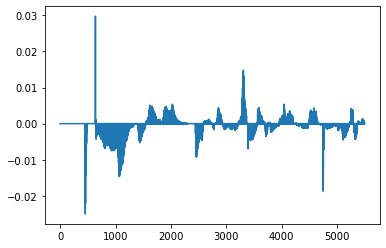

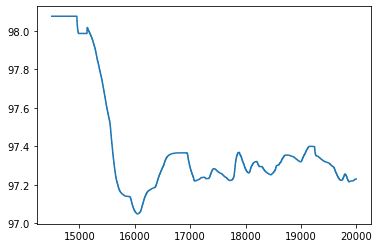

In [81]:
vel_cube1_x = []
v_previous = 0
name = 'Cube1X'
for i,v in t[name].iteritems():
    if abs(v-v_previous)>0.5:
        vel_cube1_x.append(0)
    # elif abs(v-v_previous)>0:
    else:
        vel_cube1_x.append(v-v_previous)
    v_previous = v
vel_df = pd.DataFrame({"vel_x":vel_cube1_x[14500:20000]})

# vel_df['vel_x'][vel_df['vel_x'] == 0] = np.nan
# vel_df = vel_df.interpolate(method='linear',axis=0,limit_direction ='both')
# vel_df.dropna(axis=0)
plt.plot(vel_df)
plt.show()
plt.plot(t[name][14500:20000])


In [68]:
x = np.arange(0,20*np.pi,0.1)   
y = np.sin(x)
y_small_noise = []
y_large_noise = []
for i in range(len(y)):
    small_noise = np.random.normal(0,0.5,1)
    large_noise = np.random.normal(0,1,1)
    y_small_noise.append(y[i] + small_noise)
    y_large_noise.append(y[i] + large_noise)


In [50]:
def SampEn(U, m, r):
    """
    用于量化时间序列的可预测性
    :param U: 时间序列
    :param m: 模板向量维数
    :param r: 距离容忍度，一般取0.1~0.25倍的时间序列标准差，也可以理解为相似度的度量阈值
    :return: 返回一个-np.log(A/B)，该值越小预测难度越小
    """
    def _maxdist(x_i, x_j):
        """
         Chebyshev distance
        :param x_i:
        :param x_j:
        :return:
        """
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m + 1) / _phi(m))
    
m = 2
en_origin = SampEn(y, m, r=0.2 * np.std(y))
en_small_noise = SampEn(y_small_noise, m, r=0.2 * np.std(y_small_noise))
en_large_noise = SampEn(y_large_noise, m, r=0.2 * np.std(y_large_noise)) 

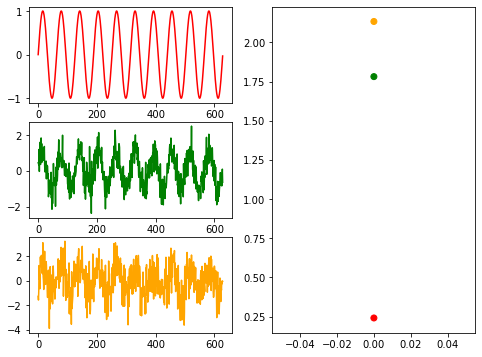

In [60]:
plt.figure(figsize=(8,6))
plt.subplot(321)
plt.plot(y,c="red")
plt.subplot(323)
plt.plot(y_small_noise,c="green")
plt.subplot(325)
plt.plot(y_large_noise,c="orange")
plt.subplot(122)
plt.scatter([0,0,0],[en_origin,en_small_noise,en_large_noise],c=["red","green","orange"])
plt.show()
